In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df=pd.read_csv("C:\\Users\\Administrator\\Downloads\\mw_pw_profiles.txt",low_memory=False)

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
df.head()

,player_id,match_id,gender,balls_per_over,start_date,series_name,match_type,name_x,runs_scored,player_out,balls_faced,fours_scored,sixes_scored,catches_taken,run_out_direct,run_out_throw,stumpings_done,out_kind,dot_balls_as_batsman,order_seen,balls_bowled,runs_conceded,wickets_taken,bowled_done,lbw_done,maidens,dot_balls_as_bowler,player_team,opposition_team,name_y,unique_name,key_bcci,key_bcci_2,key_bigbash,key_cricbuzz,key_cricheroes,key_crichq,key_cricinfo,key_cricinfo_2,key_cricinfo_3,key_cricingif,key_cricketarchive,key_cricketarchive_2,key_cricketworld,key_nvplay,key_nvplay_2,key_opta,key_opta_2,key_pulse,key_pulse_2,full_name,batting_style,bowling_style,playing_role,teams,fantasy_score_batting,fantasy_score_bowling,fantasy_score_total
0,00015688,1158348,female,6,2018-08-21,Botswana Cricket Association Women's T20I Series,T20,M King,10,1,30,1,0,1,0,0,0,run out,24,1,0,0,0,0,0,0,0,Sierra Leone,Namibia,M King,M King,NaN,NaN,NaN,NaN,NaN,NaN,1158425.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],5,8,17
1,00015688,1182644,female,6,2019-05-05,ICC Women's T20 World Cup Africa Region Qualifier,T20,M King,8,1,18,1,0,0,0,0,0,0,14,0,0,0,0,0,0,0,0,Sierra Leone,Uganda,M King,M King,NaN,NaN,NaN,NaN,NaN,NaN,1158425.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],3,0,7
2,00015688,1275107,female,6,2021-09-09,ICC Women's T20 World Cup Africa Region Qualifier,T20,M King,1,0,5,0,0,0,0,0,0,0,4,10,0,0,0,0,0,0,0,Sierra Leone,Nigeria,M King,M King,NaN,NaN,NaN,NaN,NaN,NaN,1158425.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],1,0,5
3,00015688,1275113,female,6,2021-09-15,ICC Women's T20 World Cup Africa Region Qualifier,T20,M King,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Sierra Leone,Cameroon,M King,M King,NaN,NaN,NaN,NaN,NaN,NaN,1158425.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],0,0,4
4,00015688,1275125,female,6,2021-09-14,ICC Women's T20 World Cup Africa Region Qualifier,T20,M King,1,1,15,0,0,0,0,0,0,caught and bowled,14,4,0,0,0,0,0,0,0,Sierra Leone,Uganda,M King,M King,NaN,NaN,NaN,NaN,NaN,NaN,1158425.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],-5,0,-1


In [4]:
df_t20 = df[df['match_type'].isin(['T20', 'IT20'])]

In [5]:
df_t20['start_date'] = pd.to_datetime(df_t20['start_date'], errors='coerce')
df_t20 = df_t20.sort_values(by=['player_id', 'start_date'])

C:\Users\Administrator\AppData\Local\Temp\ipykernel_7856\2796886576.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_t20['start_date'] = pd.to_datetime(df_t20['start_date'], errors='coerce')


In [6]:
df_t20['strike_rate'] = np.where(df_t20['balls_faced'] != 0, (df_t20['runs_scored'] / df_t20['balls_faced']) * 100, 0)
df_t20['total_boundaries']=df_t20['fours_scored']+df_t20['sixes_scored']
df_t20['run_out_direct']=df_t20['run_out_direct']+df_t20['run_out_throw']
df_t20['fielding']=df_t20['catches_taken']+df_t20['run_out_direct']+df_t20['stumpings_done']
df_t20['economy'] = np.where(df_t20['balls_bowled'] > 0,(df_t20['runs_conceded'] * df_t20['balls_per_over']) / df_t20['balls_bowled'],0)
df_t20['is_fifty'] = df_t20['runs_scored'].apply(lambda x: 1 if 50 <= x < 100 else 0)
df_t20['is_century'] = df_t20['runs_scored'].apply(lambda x: 1 if x >= 100 else 0)

In [7]:
df_t20['order_seen'].value_counts()

order_seen
0     164007
1      11771
2      11769
3      11741
4      11636
5      11309
6      10515
7       9143
8       7268
9       5230
10      3465
11      1848
12         3
Name: count, dtype: int64

In [8]:
df_t20 = df_t20[df_t20['order_seen'] != 12]

In [9]:
order_seen_filtered = df_t20['order_seen'].where(df_t20['order_seen'] != 0)

df_t20['rolling_order'] = (
    df_t20.groupby('player_id')[order_seen_filtered.name]
      .transform(lambda x: x.dropna().rolling(window=3, min_periods=1).mean())
)

df_t20['rolling_bowled'] = (
    df_t20.groupby('player_id')['balls_bowled']
      .transform(lambda x: x.rolling(window=3, min_periods=1).mean())
)

def classify_role(row):
    if pd.isna(row['rolling_order']) and row['rolling_bowled'] > 6:
        return 'bowler'
    elif pd.isna(row['rolling_bowled']) and row['rolling_order'] > 0:
        return 'batsman'
    elif row['rolling_order'] <= 5 and row['rolling_bowled'] < 6:
        return 'batsman'
    elif row['rolling_order'] >= 6 and row['rolling_bowled'] >= 6:
        return 'all-rounder'
    elif row['rolling_bowled'] >= 12:
        return 'bowler'
    elif row['rolling_order'] <= 6:
        return 'batsman'
    else:
        return 'unknown'

df_t20['player_role'] = df_t20.apply(classify_role, axis=1)

# role_dummies = pd.get_dummies(df_t20['player_role'], prefix='role',dtype=int)
# df_t20 = pd.concat([df_t20, role_dummies], axis=1)

In [10]:
df_t20['player_role'].value_counts()

player_role
batsman        133807
bowler         117696
all-rounder      6459
unknown          1740
Name: count, dtype: int64

In [11]:
df_t20=df_t20.drop(['order_seen','stumpings_done','balls_per_over','key_cricinfo','gender','run_out_direct','catches_taken','run_out_throw','lbw_done','bowled_done','teams','out_kind','name_y','unique_name','run_out_throw','key_bcci','key_bcci_2','key_bigbash','key_cricbuzz','key_cricheroes','key_crichq','key_cricinfo_2','key_cricinfo_3','key_cricingif','key_cricketarchive','key_cricketarchive_2','key_cricketworld','key_nvplay','key_nvplay_2','key_opta','key_opta_2','key_pulse','key_pulse_2','full_name','batting_style','bowling_style','playing_role'],axis=1,errors='ignore')

In [12]:
df_t20.head()

,player_id,match_id,start_date,series_name,match_type,name_x,runs_scored,player_out,balls_faced,fours_scored,sixes_scored,dot_balls_as_batsman,balls_bowled,runs_conceded,wickets_taken,maidens,dot_balls_as_bowler,player_team,opposition_team,fantasy_score_batting,fantasy_score_bowling,fantasy_score_total,strike_rate,total_boundaries,fielding,economy,is_fifty,is_century,rolling_order,rolling_bowled,player_role
0,00015688,1158348,2018-08-21,Botswana Cricket Association Women's T20I Series,T20,M King,10,1,30,1,0,24,0,0,0,0,0,Sierra Leone,Namibia,5,8,17,33.333333,1,1,0.0,0,0,1.000000,0.0,batsman
1,00015688,1182644,2019-05-05,ICC Women's T20 World Cup Africa Region Qualifier,T20,M King,8,1,18,1,0,14,0,0,0,0,0,Sierra Leone,Uganda,3,0,7,44.444444,1,0,0.0,0,0,0.500000,0.0,batsman
2,00015688,1275107,2021-09-09,ICC Women's T20 World Cup Africa Region Qualifier,T20,M King,1,0,5,0,0,4,0,0,0,0,0,Sierra Leone,Nigeria,1,0,5,20.000000,0,0,0.0,0,0,3.666667,0.0,batsman
4,00015688,1275125,2021-09-14,ICC Women's T20 World Cup Africa Region Qualifier,T20,M King,1,1,15,0,0,14,0,0,0,0,0,Sierra Leone,Uganda,-5,0,-1,6.666667,0,0,0.0,0,0,4.666667,0.0,batsman
3,00015688,1275113,2021-09-15,ICC Women's T20 World Cup Africa Region Qualifier,T20,M King,0,0,0,0,0,0,0,0,0,0,0,Sierra Leone,Cameroon,0,0,4,0.000000,0,0,0.0,0,0,4.666667,0.0,batsman


In [33]:
pd.set_option('display.max_columns', None)
df_t20[df_t20['player_id']=='ba607b88'].head()

,player_id,match_id,start_date,series_name,match_type,name_x,runs_scored,player_out,balls_faced,fours_scored,sixes_scored,dot_balls_as_batsman,balls_bowled,runs_conceded,wickets_taken,maidens,dot_balls_as_bowler,player_team,opposition_team,fantasy_score_batting,fantasy_score_bowling,fantasy_score_total,strike_rate,total_boundaries,fielding,economy,is_fifty,is_century,rolling_order,rolling_bowled,player_role
299534,ba607b88,335982,2008-04-18,Indian Premier League,T20,V Kohli,1,1,5,0,0,4,0,0,0,0,0,Royal Challengers Bangalore,Kolkata Knight Riders,1,0,5,20.000000,0,0,0.0,0,0,0.000000,0.0,batsman
299535,ba607b88,335985,2008-04-20,Indian Premier League,T20,V Kohli,23,1,15,3,1,6,0,0,0,0,0,Royal Challengers Bangalore,Mumbai Indians,32,16,52,153.333333,4,2,0.0,0,0,0.000000,0.0,batsman
299536,ba607b88,335992,2008-04-26,Indian Premier League,T20,V Kohli,13,1,16,0,1,9,0,0,0,0,0,Royal Challengers Bangalore,Rajasthan Royals,15,0,19,81.250000,1,0,0.0,0,0,1.666667,0.0,batsman
299537,ba607b88,335996,2008-04-28,Indian Premier League,T20,V Kohli,12,1,7,2,0,2,0,0,0,0,0,Royal Challengers Bangalore,Chennai Super Kings,14,0,18,171.428571,2,0,0.0,0,0,1.666667,0.0,batsman
299538,ba607b88,335998,2008-04-30,Indian Premier League,T20,V Kohli,1,0,1,0,0,0,6,11,0,0,0,Royal Challengers Bangalore,Delhi Daredevils,1,0,5,100.000000,0,0,11.0,0,0,1.666667,2.0,batsman


In [14]:
numeric_df = df_t20.select_dtypes(include='number')
corr_matrix = numeric_df.corr()
corr_matrix

,runs_scored,player_out,balls_faced,fours_scored,sixes_scored,dot_balls_as_batsman,balls_bowled,runs_conceded,wickets_taken,maidens,dot_balls_as_bowler,fantasy_score_batting,fantasy_score_bowling,fantasy_score_total,strike_rate,total_boundaries,fielding,economy,is_fifty,is_century,rolling_order,rolling_bowled
runs_scored,1.000000,0.259947,0.921181,0.878265,0.747337,0.712382,-0.282489,-0.257791,-0.172237,-0.049189,-0.260842,0.991089,-0.153306,0.596560,0.634128,0.954354,0.081044,-0.231590,0.680923,0.293870,0.002137,-0.311029
player_out,0.259947,1.000000,0.364414,0.237886,0.137165,0.441436,-0.336974,-0.303917,-0.228200,-0.071286,-0.311037,0.227426,-0.214508,-0.006971,0.323499,0.232642,0.047573,-0.260673,0.061341,-0.009769,0.112310,-0.364583
balls_faced,0.921181,0.364414,1.000000,0.794441,0.562630,0.902629,-0.320885,-0.304073,-0.202655,-0.051543,-0.286359,0.879756,-0.180889,0.493290,0.519663,0.818350,0.076337,-0.272322,0.588666,0.202249,0.011529,-0.351401
fours_scored,0.878265,0.237886,0.794441,1.000000,0.473602,0.637313,-0.262211,-0.240946,-0.157941,-0.042956,-0.239349,0.876015,-0.140264,0.523611,0.564111,0.937151,0.073900,-0.220994,0.604107,0.252608,-0.043214,-0.288680
sixes_scored,0.747337,0.137165,0.562630,0.473602,1.000000,0.403482,-0.161151,-0.134313,-0.094832,-0.034195,-0.157241,0.778324,-0.086095,0.496099,0.534221,0.751148,0.052317,-0.116563,0.528946,0.319547,0.014416,-0.178426
dot_balls_as_batsman,0.712382,0.441436,0.902629,0.637313,0.403482,1.000000,-0.315540,-0.307598,-0.203870,-0.045377,-0.270634,0.659704,-0.183000,0.331502,0.357849,0.637529,0.058395,-0.275512,0.412227,0.121821,-0.001778,-0.343739
balls_bowled,-0.282489,-0.336974,-0.320885,-0.262211,-0.161151,-0.315540,1.000000,0.886398,0.619917,0.146972,0.901003,-0.273400,0.588566,0.273470,-0.240507,-0.260377,-0.116892,0.689058,-0.136299,-0.036466,-0.005894,0.919943
runs_conceded,-0.257791,-0.303917,-0.304073,-0.240946,-0.134313,-0.307598,0.886398,1.000000,0.460075,0.013388,0.664108,-0.247229,0.387292,0.131637,-0.200759,-0.233805,-0.114209,0.853485,-0.124708,-0.032354,-0.011920,0.834223
wickets_taken,-0.172237,-0.228200,-0.202655,-0.157941,-0.094832,-0.203870,0.619917,0.460075,1.000000,0.207710,0.658423,-0.164563,0.965232,0.654294,-0.155175,-0.155950,-0.071882,0.308804,-0.079179,-0.020391,-0.014301,0.557398
maidens,-0.049189,-0.071286,-0.051543,-0.042956,-0.034195,-0.045377,0.146972,0.013388,0.207710,1.000000,0.275383,-0.047978,0.293243,0.199770,-0.056877,-0.045743,-0.012212,-0.009353,-0.020779,-0.004860,-0.001876,0.140379


In [15]:
df_enriched=df_t20[['player_id','start_date','match_id','player_role','rolling_order','rolling_bowled','fantasy_score_total']]
df_enriched = df_enriched.sort_values(by=['player_id', 'start_date'])

In [16]:
decay_rate=0.9
def weighted_average_past_scores(series):
    result = []
    for i in range(len(series)):
        past_scores = series[:i]  
        if len(past_scores) == 0:
            result.append(np.nan)
        else:
            weights = np.array([decay_rate ** (i - j - 1) for j in range(i)])
            weights = weights / weights.sum()  
            weighted_avg = np.dot(weights, past_scores)
            result.append(weighted_avg)
    return pd.Series(result, index=series.index)

df_enriched['weighted_bowling'] = (df_t20.groupby('player_id')['fantasy_score_bowling'].apply(weighted_average_past_scores).reset_index(level=0, drop=True))
df_enriched['weighted_batting'] = (df_t20.groupby('player_id')['fantasy_score_batting'].apply(weighted_average_past_scores).reset_index(level=0, drop=True))
df_enriched['weighted_dotballs_bowler'] = (df_t20.groupby('player_id')['dot_balls_as_bowler'].apply(weighted_average_past_scores).reset_index(level=0, drop=True))
df_enriched['weighted_runs_conceded'] = (df_t20.groupby('player_id')['runs_conceded'].apply(weighted_average_past_scores).reset_index(level=0, drop=True))
df_enriched['weighted_centuries'] = (df_t20.groupby('player_id')['is_century'].apply(weighted_average_past_scores).reset_index(level=0, drop=True))
df_enriched['weighted_fifties'] = (df_t20.groupby('player_id')['is_fifty'].apply(weighted_average_past_scores).reset_index(level=0, drop=True))
df_enriched['weighted_dotballs_batsmen'] = (df_t20.groupby('player_id')['dot_balls_as_batsman'].apply(weighted_average_past_scores).reset_index(level=0, drop=True))
df_enriched['weighted_balls_faced'] = (df_t20.groupby('player_id')['balls_faced'].apply(weighted_average_past_scores).reset_index(level=0, drop=True))
df_enriched['weighted_avg_runs'] = (df_t20.groupby('player_id')['runs_scored'].apply(weighted_average_past_scores).reset_index(level=0, drop=True))
df_enriched['weighted_avg_strike_rate'] = (df_t20.groupby('player_id')['strike_rate'].apply(weighted_average_past_scores).reset_index(level=0, drop=True))
df_enriched['weighted_avg_economy'] = (df_t20.groupby('player_id')['economy'].apply(weighted_average_past_scores).reset_index(level=0, drop=True))
df_enriched['weighted_avg_wickets'] = (df_t20.groupby('player_id')['wickets_taken'].apply(weighted_average_past_scores).reset_index(level=0, drop=True))
df_enriched['weighted_avg_boundaries'] = (df_t20.groupby('player_id')['total_boundaries'].apply(weighted_average_past_scores).reset_index(level=0, drop=True))
df_enriched['weighted_fielding'] = (df_t20.groupby('player_id')['fielding'].apply(weighted_average_past_scores).reset_index(level=0, drop=True))

In [17]:
df_enriched = df_enriched.groupby('player_id', group_keys=False).apply(lambda g: g.iloc[1:]).reset_index(drop=True)


C:\Users\Administrator\AppData\Local\Temp\ipykernel_7856\1967713865.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_enriched = df_enriched.groupby('player_id', group_keys=False).apply(lambda g: g.iloc[1:]).reset_index(drop=True)


In [18]:
df_enriched.head()

,player_id,start_date,match_id,player_role,rolling_order,rolling_bowled,fantasy_score_total,weighted_bowling,weighted_batting,weighted_dotballs_bowler,weighted_runs_conceded,weighted_centuries,weighted_fifties,weighted_dotballs_batsmen,weighted_balls_faced,weighted_avg_runs,weighted_avg_strike_rate,weighted_avg_economy,weighted_avg_wickets,weighted_avg_boundaries,weighted_fielding
0,00015688,2019-05-05,1182644,batsman,0.500000,0.0,7,8.000000,5.000000,0.0,0.0,0.0,0.0,24.000000,30.000000,10.000000,33.333333,0.0,0.0,1.000000,1.000000
1,00015688,2021-09-09,1275107,batsman,3.666667,0.0,5,3.789474,3.947368,0.0,0.0,0.0,0.0,18.736842,23.684211,8.947368,39.181287,0.0,0.0,1.000000,0.473684
2,00015688,2021-09-14,1275125,batsman,4.666667,0.0,-1,2.391144,2.859779,0.0,0.0,0.0,0.0,13.298893,16.789668,6.014760,32.103321,0.0,0.0,0.630996,0.298893
3,00015688,2021-09-15,1275113,batsman,4.666667,0.0,4,1.695842,0.574295,0.0,0.0,0.0,0.0,13.502762,16.269264,4.556557,24.706795,0.0,0.0,0.447514,0.211980
4,00029c30,2021-10-16,1283024,batsman,4.500000,6.0,4,33.000000,0.000000,6.0,16.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,8.0,1.0,0.000000,0.000000


In [19]:
groups = df_enriched['player_role'].unique()
grouped_dfs = {role: df_enriched[df_enriched['player_role'] == role].copy() for role in groups}

In [20]:
role_features = {
    'batsman': ['rolling_order','weighted_avg_runs','weighted_avg_strike_rate','weighted_avg_boundaries','weighted_fielding','weighted_balls_faced','weighted_dotballs_batsmen','weighted_fifties','weighted_centuries','weighted_batting'],
    
    'bowler': ['rolling_bowled','weighted_avg_economy','weighted_avg_wickets','weighted_fielding','weighted_runs_conceded','weighted_dotballs_bowler','weighted_bowling'],
    
    'allrounder': ['rolling_order','weighted_avg_runs','weighted_avg_strike_rate','weighted_avg_boundaries','weighted_fielding','rolling_bowled','weighted_avg_economy','weighted_avg_wickets','weighted_balls_faced','weighted_dotballs_batsmen','weighted_fifties','weighted_centuries','weighted_batting','weighted_runs_conceded','weighted_dotballs_bowler','weighted_bowling'],
    
    'unknown': ['rolling_order','weighted_avg_runs','weighted_avg_strike_rate','weighted_avg_boundaries','weighted_fielding','rolling_bowled','weighted_avg_economy','weighted_avg_wickets','weighted_balls_faced','weighted_dotballs_batsmen','weighted_fifties','weighted_centuries','weighted_batting','weighted_runs_conceded','weighted_dotballs_bowler','weighted_bowling']  # you can default this to a union of all or minimal set
}


In [22]:
df_batsmen = df_enriched[df_enriched['player_role'] == 'batsman']
df_batsmen = df_batsmen.dropna(subset=['fantasy_score_total'])

X_bat = df_batsmen[role_features['batsman']]
y_bat = df_batsmen['fantasy_score_total']

from sklearn.model_selection import train_test_split
X_train_bat, X_test_bat, y_train_bat, y_test_bat = train_test_split(X_bat, y_bat, test_size=0.2, random_state=42)

from xgboost import XGBRegressor
model = XGBRegressor(
    objective='reg:squarederror',
    learning_rate=0.03,        
    max_depth=4,
    n_estimators=1000,         
    subsample=0.7,             
    colsample_bytree=0.7,      
    reg_alpha=0.5,             
    reg_lambda=1.0,            
    random_state=42,
    n_jobs=-1,
    verbosity=0
)

print("Training XGBoost...")
model.fit(X_train_bat, y_train_bat)
importances = model.feature_importances_
for feat, imp in sorted(zip(X_train_bat.columns, importances), key=lambda x: -x[1]):
    print(f"{feat}: {imp:.4f}")


Training XGBoost...
weighted_batting: 0.2536
weighted_avg_boundaries: 0.2341
weighted_fifties: 0.1035
weighted_avg_runs: 0.0711
weighted_centuries: 0.0675
weighted_avg_strike_rate: 0.0624
rolling_order: 0.0613
weighted_fielding: 0.0543
weighted_dotballs_batsmen: 0.0485
weighted_balls_faced: 0.0438


In [23]:
y_pred_bat = model.predict(X_test_bat)
from sklearn.metrics import mean_squared_error, r2_score
print(r2_score(y_test_bat, y_pred_bat))

0.08746302127838135


In [24]:
y_pred_bat = model.predict(X_train_bat)
from sklearn.metrics import mean_squared_error, r2_score
print(r2_score(y_train_bat, y_pred_bat))

0.12992167472839355


Number of components selected: 6


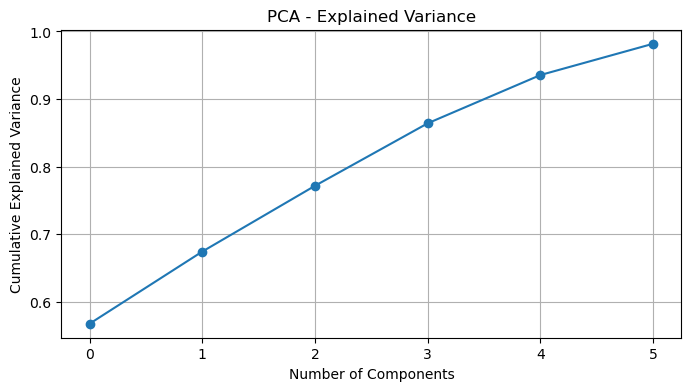

In [25]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

X_scaled_bat = StandardScaler().fit_transform(X_bat)

pca = PCA(n_components=0.95)  # Retain 95% variance
X_pca = pca.fit_transform(X_scaled_bat)

print("Number of components selected:", pca.n_components_)

# Plot explained variance
plt.figure(figsize=(8, 4))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA - Explained Variance')
plt.grid(True)
plt.show()

100%|===================| 128781/128805 [75:52<00:00]        

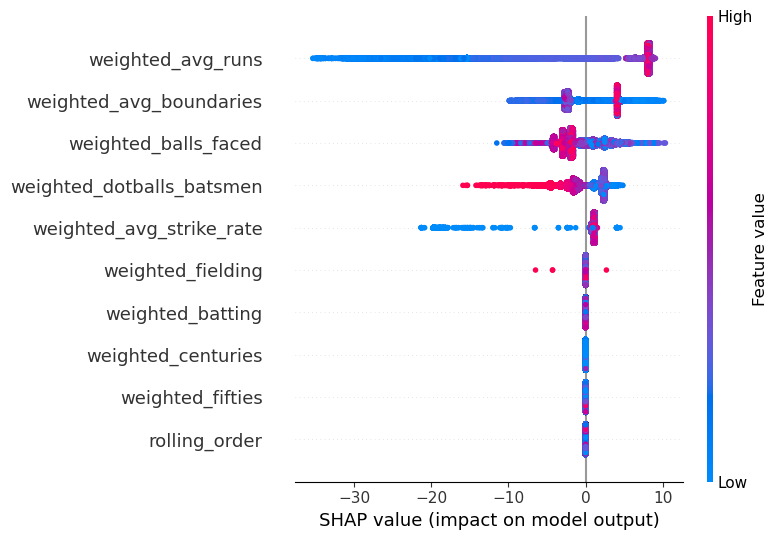

In [30]:
import shap

# Explain model predictions using SHAP
explainer = shap.Explainer(model, X_bat)
shap_values = explainer(X_bat)

# Summary plot
shap.summary_plot(shap_values, X_bat)

In [26]:
df_bowler = df_enriched[df_enriched['player_role'] == 'bowler']
df_bowler = df_bowler.dropna(subset=['fantasy_score_total'])

X_bowl = df_bowler[role_features['bowler']]
y_bowl = df_bowler['fantasy_score_total']

from sklearn.model_selection import train_test_split
X_train_bowl, X_test_bowl, y_train_bowl, y_test_bowl = train_test_split(X_bowl, y_bowl, test_size=0.2, random_state=42)

from xgboost import XGBRegressor
model = XGBRegressor(
    objective='reg:squarederror',
    learning_rate=0.03,        
    max_depth=4,               
    n_estimators=1000,         
    subsample=0.7,             
    colsample_bytree=0.7,      
    reg_alpha=0.5,             
    reg_lambda=1.0,            
    random_state=42,
    n_jobs=-1,
    verbosity=0
)

print("Training XGBoost...")
model.fit(X_train_bowl, y_train_bowl)
importances = model.feature_importances_
for feat, imp in sorted(zip(X_train_bowl.columns, importances), key=lambda x: -x[1]):
    print(f"{feat}: {imp:.4f}")

Training XGBoost...
rolling_bowled: 0.3129
weighted_runs_conceded: 0.1506
weighted_dotballs_bowler: 0.1447
weighted_fielding: 0.1304
weighted_avg_economy: 0.0902
weighted_avg_wickets: 0.0870
weighted_bowling: 0.0841


In [27]:
y_pred_bowl = model.predict(X_test_bowl)
from sklearn.metrics import mean_squared_error, r2_score
print(r2_score(y_test_bowl, y_pred_bowl))

0.05678147077560425


In [28]:
y_pred_bowl = model.predict(X_train_bowl)
from sklearn.metrics import mean_squared_error, r2_score
print(r2_score(y_train_bowl, y_pred_bowl))

0.09276717901229858


Number of components selected: 5


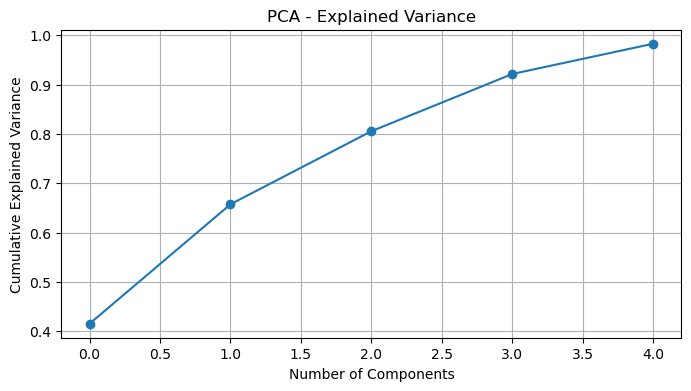

In [29]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

X_scaled_bowl = StandardScaler().fit_transform(X_bowl)

pca = PCA(n_components=0.95)  # Retain 95% variance
X_pca = pca.fit_transform(X_scaled_bowl)

print("Number of components selected:", pca.n_components_)

# Plot explained variance
plt.figure(figsize=(8, 4))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA - Explained Variance')
plt.grid(True)
plt.show()

In [31]:
numeric_df = df_enriched.select_dtypes(include='number')
corr = numeric_df.corr()
corr

,rolling_order,rolling_bowled,fantasy_score_total,weighted_bowling,weighted_batting,weighted_dotballs_bowler,weighted_runs_conceded,weighted_centuries,weighted_fifties,weighted_dotballs_batsmen,weighted_balls_faced,weighted_avg_runs,weighted_avg_strike_rate,weighted_avg_economy,weighted_avg_wickets,weighted_avg_boundaries,weighted_fielding
rolling_order,1.000000,0.001113,-0.014896,0.010156,-0.051948,0.016428,0.020008,-0.059918,-0.099381,-0.053479,-0.040622,-0.045751,0.113846,0.051871,0.008570,-0.076915,0.003350
rolling_bowled,0.001113,1.000000,0.191607,0.802367,-0.545501,0.900690,0.898968,-0.131598,-0.379554,-0.535413,-0.575570,-0.550760,-0.480893,0.831832,0.823436,-0.518676,-0.307010
fantasy_score_total,-0.014896,0.191607,1.000000,0.135387,0.104528,0.123857,0.118675,0.045803,0.094992,0.039583,0.071414,0.101898,0.092324,0.106369,0.127517,0.109661,0.016191
weighted_bowling,0.010156,0.802367,0.135387,1.000000,-0.463524,0.856071,0.768826,-0.112137,-0.322263,-0.472955,-0.500557,-0.471364,-0.411268,0.682075,0.980410,-0.443031,-0.144420
weighted_batting,-0.051948,-0.545501,0.104528,-0.463524,1.000000,-0.558462,-0.548113,0.365873,0.809235,0.746722,0.908690,0.993283,0.815825,-0.519197,-0.493660,0.978536,0.303329
weighted_dotballs_bowler,0.016428,0.900690,0.123857,0.856071,-0.558462,1.000000,0.854610,-0.131123,-0.384304,-0.513519,-0.570606,-0.561091,-0.511043,0.770199,0.853424,-0.530336,-0.311134
weighted_runs_conceded,0.020008,0.898968,0.118675,0.768826,-0.548113,0.854610,1.000000,-0.133163,-0.383603,-0.575378,-0.601852,-0.557707,-0.463400,0.944022,0.822497,-0.519438,-0.311016
weighted_centuries,-0.059918,-0.131598,0.045803,-0.112137,0.365873,-0.131123,-0.133163,1.000000,0.196655,0.212971,0.275181,0.352863,0.201755,-0.130844,-0.117917,0.380273,0.053399
weighted_fifties,-0.099381,-0.379554,0.094992,-0.322263,0.809235,-0.384304,-0.383603,0.196655,1.000000,0.566310,0.712785,0.801265,0.532435,-0.370906,-0.342858,0.802086,0.187593
weighted_dotballs_batsmen,-0.053479,-0.535413,0.039583,-0.472955,0.746722,-0.513519,-0.575378,0.212971,0.566310,1.000000,0.936174,0.791768,0.558705,-0.544302,-0.505163,0.737427,0.198852


In [ ]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor

# Model
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Recursive Feature Elimination
rfe = RFE(estimator=model, n_features_to_select=10)
rfe.fit(X_bat, y_bat)

# Show top features
selected_features = X.columns[rfe.support_]
print("Top 10 selected features by RFE:")
print(selected_features)


In [ ]:
!pip install xgboost

In [ ]:
!pip install shap